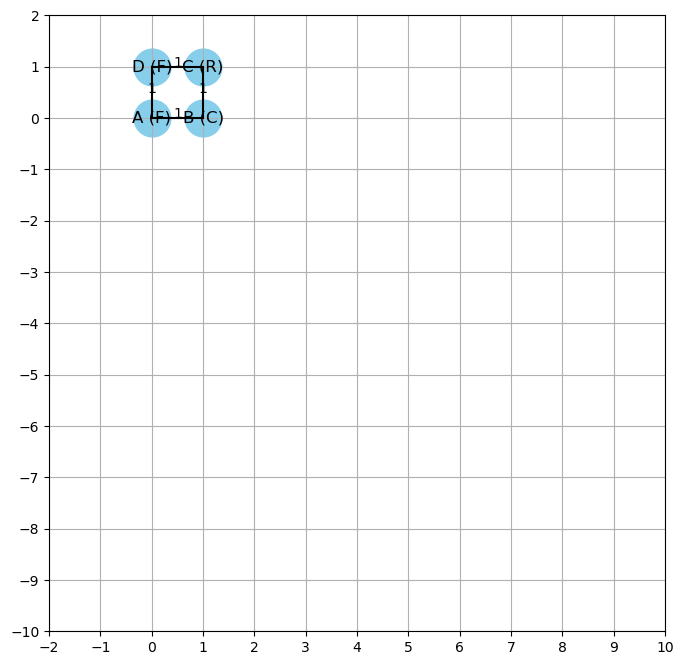

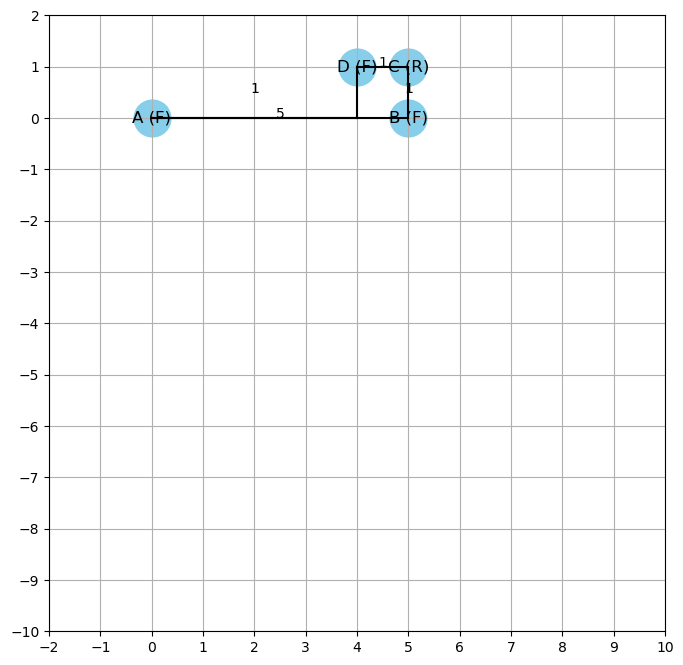

In [101]:
import matplotlib.pyplot as plt
import networkx as nx

class Vertex:
    def __init__(self, label):
        self.label = label
        self.edges = {}

class Edge:
    def __init__(self, start, end, weight=1, direction=None, angle_type='F'):
        self.start = start
        self.end = end
        self.weight = weight
        self.length = weight
        self.direction = direction
        self.angle_type = angle_type

class WeightedGraph:
    def __init__(self):
        self.vertices = {}

    def add_vertex(self, key, label):
        self.vertices[key] = Vertex(label)

    def add_edge(self, start, end, weight=1, direction=None, angle_type='F'):
        if start in self.vertices and end in self.vertices:
            edge = Edge(start, end, weight, direction, angle_type)
            self.vertices[start].edges[end] = edge

    def update_edge(self, start, end, new_length=None, new_direction=None, new_angle_type=None):
        if start in self.vertices and end in self.vertices[start].edges:
            edge = self.vertices[start].edges[end]
            if new_length is not None:
                edge.length = new_length
            if new_direction is not None:
                edge.direction = new_direction
            if new_angle_type is not None:
                edge.angle_type = new_angle_type

    def change_edge_length(self, start, end, new_length):
        self.update_edge(start, end, new_length=new_length)

    def calculate_positions(self, start_key='A'):
        pos = {start_key: (0, 0)}
        grid_size = 1

        def place_vertex(vertex_key, x, y):
            pos[vertex_key] = (x, y)
            for end_key, edge in self.vertices[vertex_key].edges.items():
                if end_key not in pos:
                    length = edge.length * grid_size
                    if edge.direction == 'E':
                        place_vertex(end_key, x + length, y)
                    elif edge.direction == 'S':
                        place_vertex(end_key, x, y - length)
                    elif edge.direction == 'W':
                        place_vertex(end_key, x - length, y)
                    elif edge.direction == 'N':
                        place_vertex(end_key, x, y + length)

        place_vertex(start_key, 0, 0)
        return pos

    def draw_edges_with_bends(self, G, pos):
        for vertex_key in self.vertices:
            for end_key, edge in self.vertices[vertex_key].edges.items():
                x_start, y_start = pos[vertex_key]
                x_end, y_end = pos[end_key]

                if (x_start != x_end) and (y_start != y_end):
                    temp_x1 = x_start
                    temp_y1 = y_end
                    temp_x2 = x_end
                    temp_y2 = y_start

                    unique_x = {temp_x1, temp_x2}
                    if len(unique_x) == 2:
                        plt.plot([x_start, temp_x1], [y_start, y_start], 'k-')
                        plt.plot([temp_x1, temp_x1], [y_start, temp_y1], 'k-')
                        plt.plot([temp_x1, x_end], [temp_y1, y_end], 'k-')
                    else:
                        plt.plot([x_start, temp_x2], [y_start, y_start], 'k-')
                        plt.plot([temp_x2, temp_x2], [y_start, temp_y2], 'k-')
                        plt.plot([temp_x2, x_end], [temp_y2, y_end], 'k-')
                else:
                    plt.plot([x_start, x_end], [y_start, y_end], 'k-')

    def draw_graph(self):
        G = nx.DiGraph()
        pos = self.calculate_positions()

        for key, vertex in self.vertices.items():
            for end, edge in vertex.edges.items():
                G.add_edge(edge.start, edge.end, weight=edge.weight)

        plt.figure(figsize=(8, 8))
        self.draw_edges_with_bends(G, pos)

        for key, vertex in self.vertices.items():
            plt.scatter(*pos[key], s=700, c='skyblue')
            angle_type_symbol = vertex.edges[next(iter(vertex.edges))].angle_type if vertex.edges else ''
            plt.text(pos[key][0], pos[key][1], f"{vertex.label} ({angle_type_symbol})", fontsize=12, ha='center', va='center')

        plt.grid(True)
        plt.xlim(-2, 10)
        plt.ylim(-10, 2)
        plt.xticks(range(-2, 11))
        plt.yticks(range(-10, 3))
        plt.gca().set_aspect('equal', adjustable='box')

        for vertex_key in self.vertices:
            for end_key in self.vertices[vertex_key].edges:
                edge_length = self.vertices[vertex_key].edges[end_key].length
                plt.text((pos[vertex_key][0] + pos[end_key][0]) / 2, (pos[vertex_key][1] + pos[end_key][1]) / 2, str(edge_length), fontsize=10, ha='center')

        plt.show()

# Example usage
wg = WeightedGraph()
wg.add_vertex('A', 'A')
wg.add_vertex('B', 'B')
wg.add_vertex('C', 'C')
wg.add_vertex('D', 'D')
wg.add_edge('A', 'B', 1, 'E', 'F')
wg.add_edge('B', 'C', 1, 'N', 'C')
wg.add_edge('C', 'D', 1, 'W', 'R')
wg.add_edge('D', 'A', 1, 'S', 'F')

wg.draw_graph()

wg.change_edge_length('A', 'B', 5)
wg.update_edge('B', 'C', new_angle_type='F')
wg.draw_graph()


AttributeError: 'dict' object has no attribute 'append'

Graph Nodes: [0, 1, 2, 3, 4]
Graph Edges: [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4)]


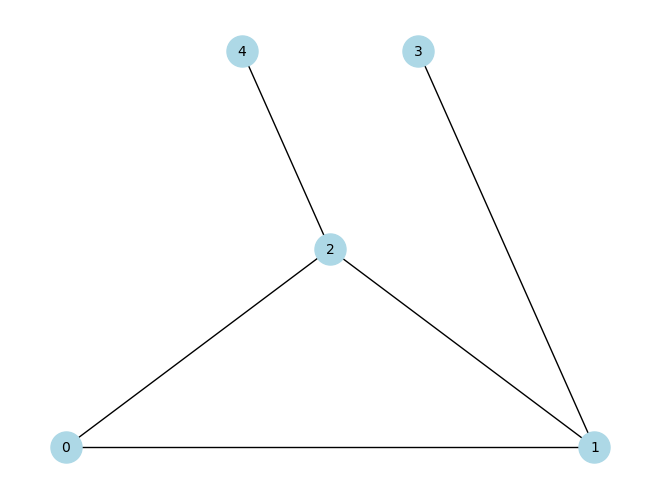

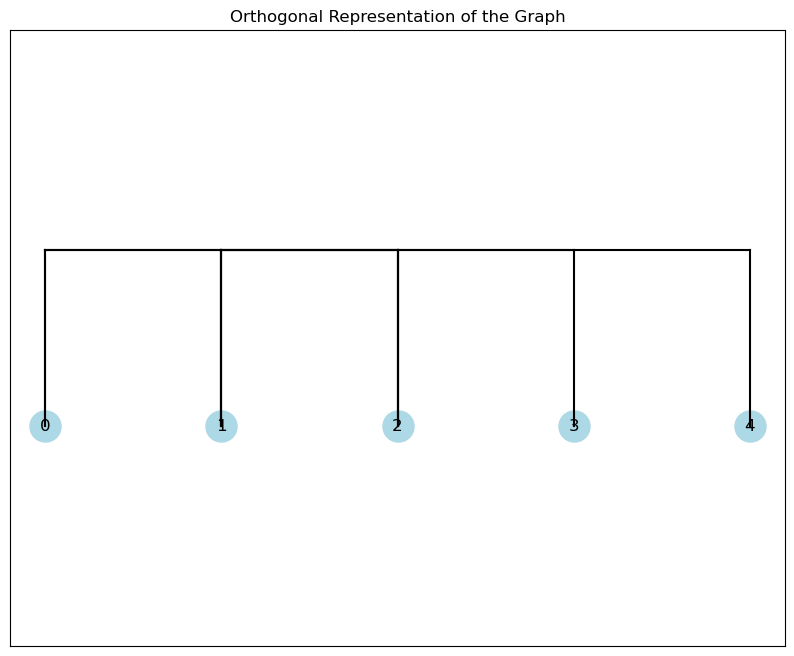

In [98]:
import networkx as nx
from networkx.algorithms.planarity import check_planarity
import matplotlib.pyplot as plt
import numpy as np

# Read the graph from a text file
def read_graph_from_file(filename):
    G = nx.Graph()
    with open(filename, 'r') as f:
        for line in f:
            u, v = map(int, line.split())
            G.add_edge(u, v)
    return G

# Compute planar embedding
def compute_planar_embedding(graph):
    is_planar, embedding = check_planarity(graph)
    if not is_planar:
        raise ValueError("The graph is not planar.")
    return embedding

# Create an orthogonal representation
def orthogonal_representation(G, embedding):
    # Determine the number of vertices
    pos = {}
    layer_height = 2
    current_layer = 0

    # Set vertex positions based on embedding
    for idx, vertex in enumerate(G.nodes()):
        pos[vertex] = (idx, 0)  # Simple horizontal layout, modify for orthogonality later

    # Draw the graph with orthogonal edges
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_labels(G, pos)

    # Draw edges with bends for orthogonal representation
    for (u, v) in G.edges():
        start = pos[u]
        end = pos[v]

        # Create orthogonal paths
        if start[0] == end[0]:  # Same vertical line
            plt.plot([start[0], start[0]], [start[1], start[1] + 1], 'k-')  # Vertical line to new height
            plt.plot([start[0], end[0]], [start[1] + 1, end[1] + 1], 'k-')  # Horizontal line
            plt.plot([end[0], end[0]], [end[1] + 1, end[1]], 'k-')  # Vertical line to end
        else:
            plt.plot([start[0], start[0]], [start[1], start[1] + 1], 'k-')  # Vertical to a new height
            plt.plot([start[0], end[0]], [start[1] + 1, start[1] + 1], 'k-')  # Horizontal line
            plt.plot([end[0], end[0]], [start[1] + 1, end[1]], 'k-')  # Vertical to end

    plt.axis('equal')
    plt.title("Orthogonal Representation of the Graph")
    plt.show()

# Visualize the planar embedding
def visualize_planar_embedding(G):
    pos = nx.planar_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black', node_size=500, font_size=10)
    plt.show()

# Main function to execute within Jupyter Notebook
def draw_first(input_file):
    G = read_graph_from_file(input_file)
    embedding = compute_planar_embedding(G)
    print("Graph Nodes:", G.nodes())
    print("Graph Edges:", G.edges())
    visualize_planar_embedding(G)
    orthogonal_representation(G, embedding)

# Call the draw_first function with your input file
draw_first('input.txt')
